In [1]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import mannwhitneyu as mwu, kstest as kst, tmean as mean
sns.set(style="darkgrid")

Please specifiy the location of the CSV file that Pyexec created

In [2]:
data = pd.read_csv("/home/michael/pyexec-output/20200921-120342/stats.csv")
data = data.replace([-1], pd.NA)

In [3]:
def pypi() -> DataFrame:
    return data[data["project_on_pypi"]]

def link() -> DataFrame:
    return data[data["github_link_found"]]

def exists() -> DataFrame:
    return data[data["github_repo_exists"]]

def mined() -> DataFrame:
    return data[data["github_repo_exists"]]

def testsuit() -> DataFrame:
    return mined()[mined()["testcase_count"] > 0]
 
def testsuit_but_no_success() -> DataFrame:
    return testsuit()[testsuit()["testsuit_result_parsed"] == False]
        
def inferred() -> DataFrame:
    return mined()[mined()["dockerfile_found"]]

def build(*, complement=False) -> DataFrame:
    return mined()[mined()["dockerimage_build_success"] != complement]

def executed() -> DataFrame:
    return build()[build()["testsuit_executed"]]
                   
def executed_but_no_success() -> DataFrame:
    return executed()[executed()["testsuit_result_parsed"] == False]
                   
def success() -> DataFrame:
    return mined()[mined()["testsuit_result_parsed"]]

hor = ["v2", "Pipfile", "setup.py", "requirements.txt"]

# Summary statistics
Total number of times a project has reached some stage.
Good to have as a sanity-check.

In [4]:
print("Attempted: {}".format(len(data)))
print("Found on PyPI: {}".format(len(pypi())))
print("GitHub link found: {}".format(len(link())))
print("GitHub link is valid: {}".format(len(exists())))
print("Mined: {}".format(len(mined())))
print("Has setup.py: {}".format(len(mined()[mined()["has_setuppy"]])))
print("Has Pipfile: {}".format(len(mined()[mined()["has_pipfile"]])))
print("Has requirements.txt: {}".format(len(mined()[mined()["has_requirementstxt"]])))
print("Has testsuit: {}".format(len(testsuit())))
print("Dockerimage inferred: {}".format(len(inferred())))
print("Dockerimage build success: {}".format(len(build())))
print("Testsuits executed: {}".format(len(executed())))
print("Testcases executed and parsed: {}".format(len(success())))

Attempted: 100
Found on PyPI: 97
GitHub link found: 67
GitHub link is valid: 66
Mined: 66
Has setup.py: 60
Has Pipfile: 3
Has requirements.txt: 22
Has testsuit: 13
Dockerimage inferred: 43
Dockerimage build success: 37
Testsuits executed: 9
Testcases executed and parsed: 6


# RQ1: Fraction of projects for which an environment is inferred
Based on the number of project for which a GitHub link has been found and which cound be cloned.
Only projects for which a dockerfile has been inferred and for which a dockerimage was build successfully are counted here.

In [5]:
print("{}%".format(len(build()) / len(mined()) * 100))

56.060606060606055%


# RQ2: Fraction of projects for which the testcases could be executed
Based on the number of projects for which a dockerimage could be build

In [6]:
print("Fraction of projects for which a testsuit was detected and executed: {}%".format(len(executed()) / len(build()) * 100))
print("Fraction of projects for which testsuit execution was successful: {}%".format(len(success()) / len(build()) * 100))

Fraction of projects for which a testsuit was detected and executed: 24.324324324324326%
Fraction of projects for which testsuit execution was successful: 16.216216216216218%


So the ratio of successful testcase executions to all testsuit executions is:

In [7]:
print("\t{}%".format(len(success()) / len(executed()) * 100))

	66.66666666666666%


# RQ3 Representativness of project for which a environment has been found

The depency interferrance step should not damage the reprentativenss for all (mined) Python projects.
To evaluate whether this property holds the distribtutions for 
* lines of code (LOC)
* number of Python implementation files
* average cyclomatic complexity
* test-case count
* minmum required Python version
* active days and
* project age 

are chosen for comparison.
Hereby Python implementation files means Python files that contain code implementing some feature.
This exculde test code, \__init__.py files and setup.py files. This is done so differnce in the actual number of Python files are not caused by one pronect haveing a (bigger) testsuit or more sub-packages.

To get a feel for the distributions they are represented as a graph down below.
Additionally the source of the inferred dependencys (V2, Pipfile, requirements.txt or None if they could not be inferred) per project is represented here.

Whenever a value is not present (for example the cyclomatic complexity is missing for some project), that is the value is NaN ("Not a number") it is ignored. This can reduce the number of datapoits used per graph, so as a santiy check the number of datapoints for graph is provided for every graph.

First of all the graphs for all mined projects:

Datapoints: 66


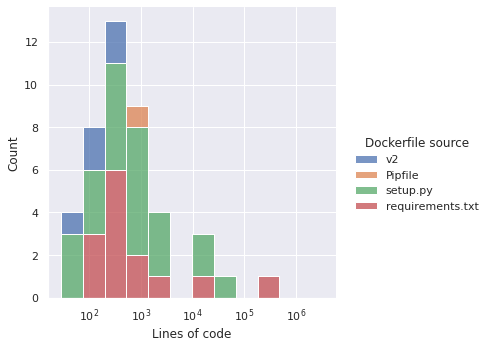

In [8]:
print("Datapoints: {}".format(len(mined()["loc"].dropna())))
g = sns.displot(mined(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 66


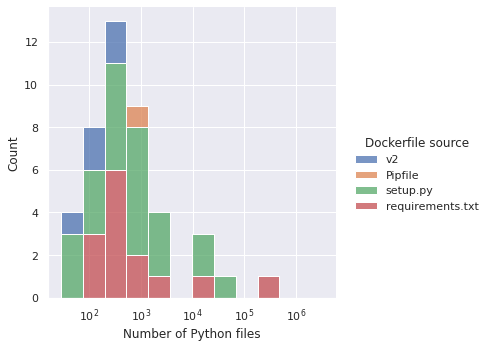

In [9]:
print("Datapoints: {}".format(len(mined()["num_impl_files"].dropna())))
g = sns.displot(mined(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 63


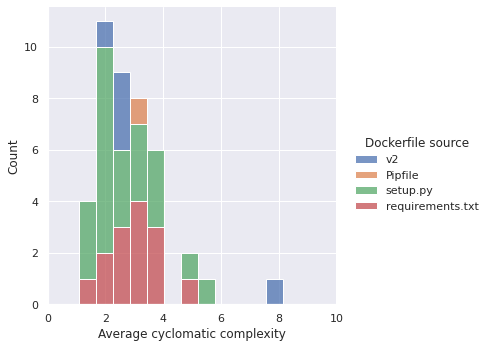

In [10]:
print("Datapoints: {}".format(len(mined()["average_complexity"].dropna())))
g = sns.displot(mined(), x="average_complexity", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity", xlim=(0,10))

Datapoints: 14


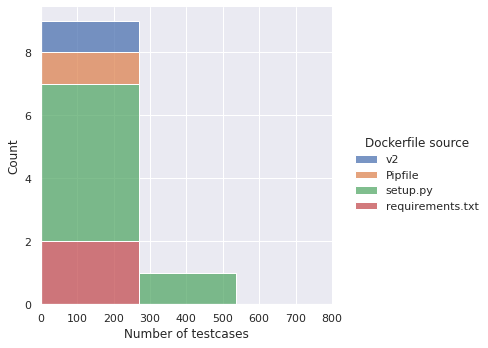

In [11]:
print("Datapoints: {}".format(len(mined()["testcase_count"].dropna())))
g = sns.displot(mined(), x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of testcases", xlim=(0,800))

Datapoints: 27


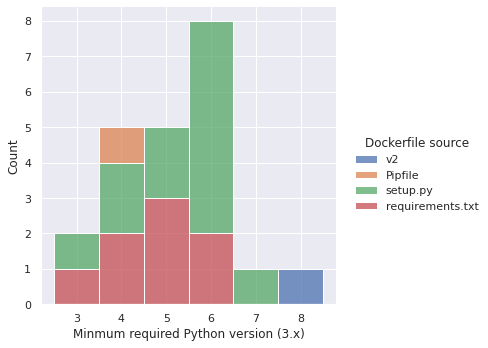

In [12]:
print("Datapoints: {}".format(len(mined()["min_python_version"].dropna())))
g = sns.displot(mined(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 64


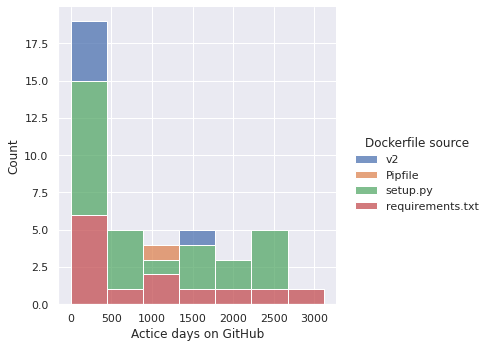

In [13]:
print("Datapoints: {}".format(len(mined()["github_repo_active_days"].dropna())))
g = sns.displot(mined(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 64


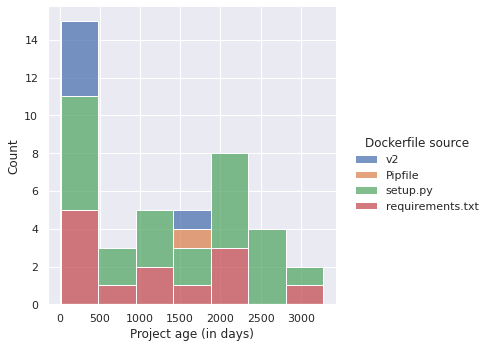

In [14]:
print("Datapoints: {}".format(len(mined()["github_repo_age"].dropna())))
g = sns.displot(mined(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

Next, the same graphs, but only taking projects into account for which dependencies cound be successfully inffered and for which a Dockerimage could be build:

Datapoints: 37


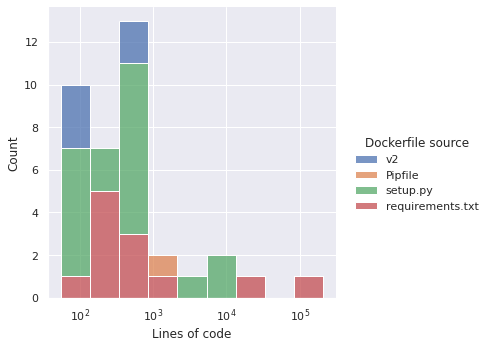

In [15]:
print("Datapoints: {}".format(len(build()["loc"].dropna())))
g = sns.displot(build(), x="loc", hue="dockerfile_source", hue_order=hor, multiple="stack", log_scale=True)
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 37


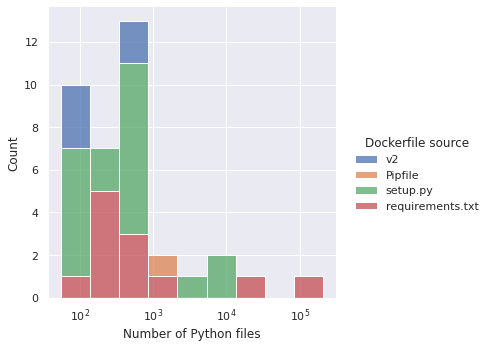

In [16]:
print("Datapoints: {}".format(len(build()["num_impl_files"].dropna())))
g = sns.displot(build(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 36


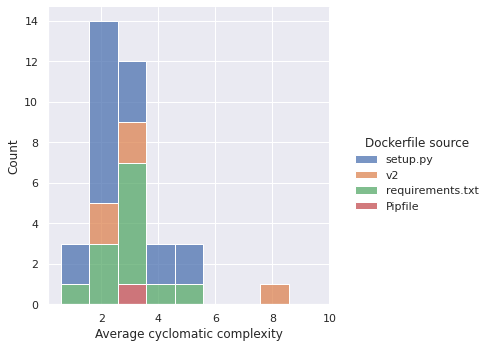

In [17]:
print("Datapoints: {}".format(len(build()["average_complexity"].dropna())))
g = sns.displot(build(), discrete=True, x="average_complexity", hue="dockerfile_source", multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity")

Datapoints: 9


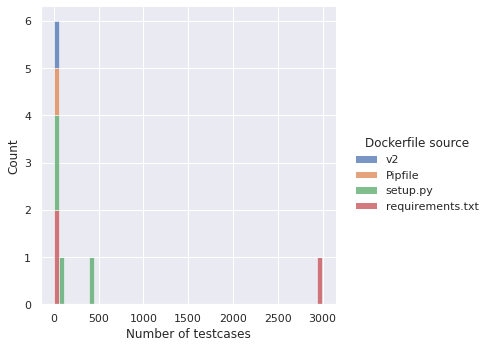

In [18]:
print("Datapoints: {}".format(len(build()["testcase_count"].dropna())))
g = sns.displot(build(), x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of testcases")

Datapoints: 19


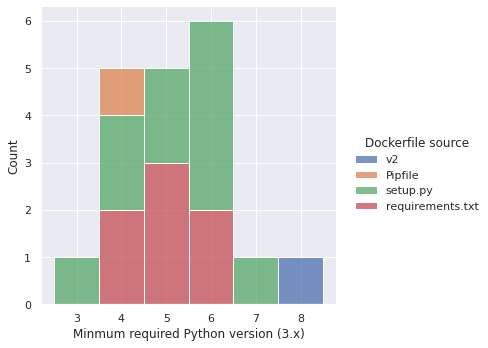

In [19]:
print("Datapoints: {}".format(len(build()["min_python_version"].dropna())))
g = sns.displot(build(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 36


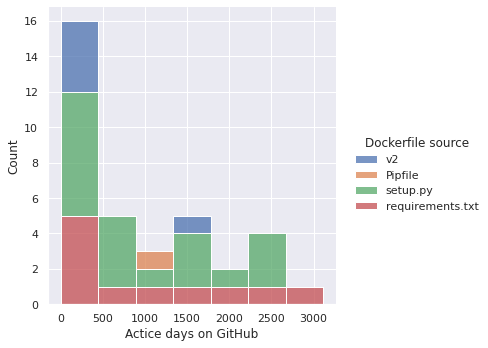

In [20]:
print("Datapoints: {}".format(len(build()["github_repo_active_days"].dropna())))
g = sns.displot(build(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 36


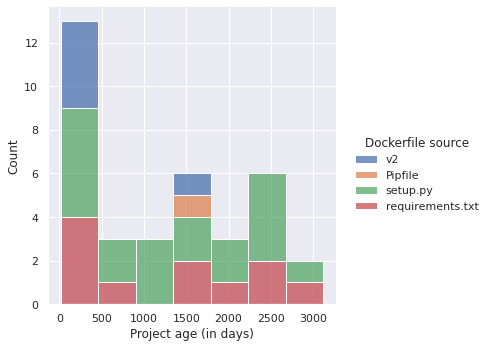

In [21]:
print("Datapoints: {}".format(len(build()["github_repo_age"].dropna())))
g = sns.displot(build(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

To test whether the distributions for these five properties are similar betweeen all mined projects and all proejcts for which dependencies could be infered and a Dockerimage be build the Mann-Whitney U-test is used:

In [22]:
print("LOC p-value: {}".format(mwu(build(complement=True)["loc"].dropna(), build()["loc"].dropna(), alternative="two-sided")[1]))
print("Num code files p-value: {}".format(mwu(build(complement=True)["num_impl_files"].dropna(), build()["num_impl_files"].dropna(), alternative="two-sided")[1]))
print("Complexity p-value: {}".format(mwu(build(complement=True)["average_complexity"].dropna(), build()["average_complexity"].dropna(), alternative="two-sided")[1]))
print("Testcase count p-value: {}".format(mwu(build(complement=True)["testcase_count"].dropna(), build()["testcase_count"].dropna(), alternative="two-sided")[1]))
print("Version p-value: {}".format(mwu(build(complement=True)["min_python_version"].dropna(), build()["min_python_version"].dropna(), alternative="two-sided")[1]))
print("Active days p-value: {}".format(mwu(build(complement=True)["github_repo_active_days"].dropna(), build()["github_repo_active_days"].dropna(), alternative="two-sided")[1]))
print("Age p-value: {}".format(mwu(build(complement=True)["github_repo_age"].dropna(), build()["github_repo_age"].dropna(), alternative="two-sided")[1]))

LOC p-value: 0.13395042387853684
Num code files p-value: 0.16600291700617442
Complexity p-value: 0.8512650954187824
Testcase count p-value: 0.42320078798386085
Version p-value: 0.8464915784423842
Active days p-value: 0.20314578763583047
Age p-value: 0.08690361081414376


## Effectiveness of the individual dependency inferrance apporaches

This section investigates how successful each of the approaches for dependency inferrence is.

That is not how many dockerfiels could be inferred by each approach.
Because the order in which the approaches are applied (v2 -> Pipfile -> Setup.py -> requirements.txt) is set and later apporaches are not attempted when a previouse apporach was successful considering how many Dockerimage wer found is only meaningful for v2.
However, we still can observe the ratio of successfully build to inferred Dockerfiles for each approach.

Moreover it would be interesting to investigate if the change a dockerimage is found, respectively is build successfully depends on the variouse properties listed above. However, because the differnt approaches are only applied in a certain order this only meaningful for v2. Luckily this is also the most interesting case.

### Ratio of successfuly build docker images

The ratio for each approach is based on the number of dockerfiles inferred

In [23]:
for s in ["v2", "Pipfile", "setup.py", "requirements.txt"]:
    print("For {}: {}%".format(s, len(build()[build()["dockerfile_source"] == s]) / len(inferred()[inferred()["dockerfile_source"] == s]) * 100))

For v2: 100.0%
For Pipfile: 100.0%
For setup.py: 82.6086956521739%
For requirements.txt: 85.71428571428571%


Moreover the absolute counts for v2 are

In [24]:
print("Inferred: {}".format(len(inferred()[inferred()["dockerfile_source"] == "v2"])))
print("That is {}% of all mined projects".format(len(inferred()[inferred()["dockerfile_source"] == "v2"]) / len(mined()) * 100))
print("Build: {}".format(len(build()[build()["dockerfile_source"] == "v2"])))
print("That is {}% of all mined projects".format(len(build()[build()["dockerfile_source"] == "v2"]) / len(mined()) * 100))

Inferred: 5
That is 7.575757575757576% of all mined projects
Build: 5
That is 7.575757575757576% of all mined projects


Additionally inspect whether the chance v2 inferres a Dockerfile depends on the variouse properties.
We will exploere these in greate detail.
For this the propeties
* Lines of Code
* Number of python files
* Code complexity

will be considered

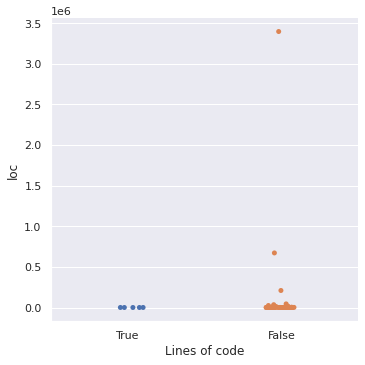

In [25]:
_m = mined().copy()
_m["v2"] =  _m["dockerfile_source"] == "v2"
g = sns.catplot(data=_m, x="v2", order=[True, False],y="loc")
g.set(xlabel="Lines of code")

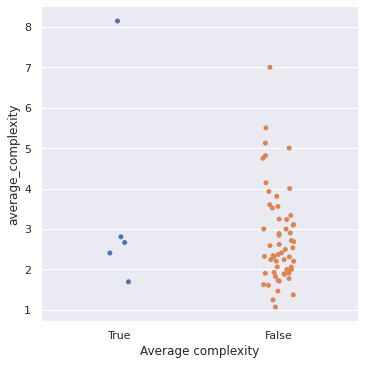

In [26]:
g = sns.catplot(data=_m, x="v2", order=[True, False],y="average_complexity")
g.set(xlabel="Average complexity")

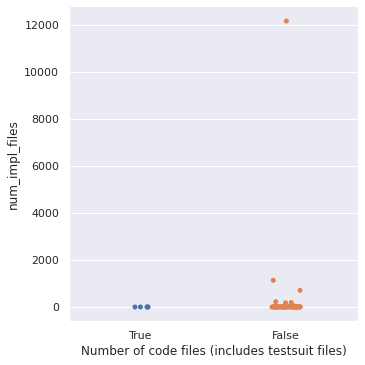

In [27]:
g = sns.catplot(data=_m, x="v2", order=[True, False],y="num_impl_files")
g.set(xlabel="Number of code files (includes testsuit files)")

To get a bit more insight it might be interesting to inspect these properties not individually, but in relation to another:

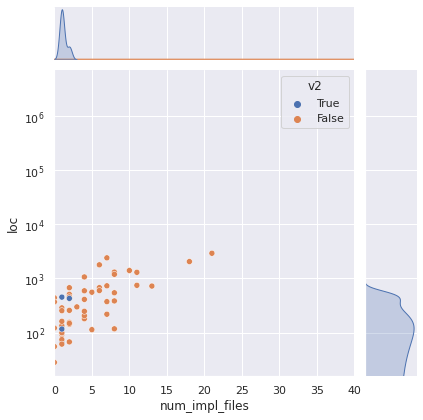

In [28]:
g = sns.jointplot(data=_m, x="num_impl_files", y="loc", hue="v2", xlim=(0,40), hue_order=[True, False])
g.ax_joint.set_yscale('log')

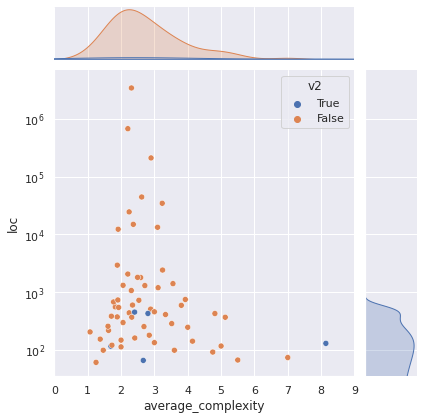

In [29]:
g = sns.jointplot(data=_m, x="average_complexity", y="loc", hue="v2", xlim=(0,9), hue_order=[True, False])
g.ax_joint.set_yscale('log')

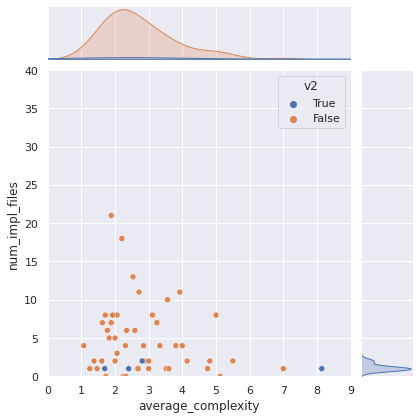

In [30]:
g = sns.jointplot(data=_m, x="average_complexity", y="num_impl_files", hue="v2", xlim=(0,9), ylim=(0,40), hue_order=[True, False])

Additionally it might be interesting to view the impact of test code files for this.
This is because we do not expect test files to contain any additional dependencies.
However, in practice exluding the test suit files from v2 led to failure of testsuit execution.

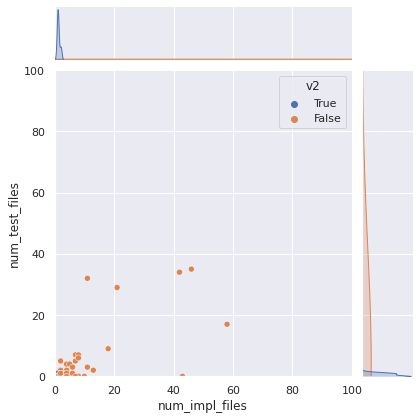

In [31]:
g = sns.jointplot(data=_m, x="num_impl_files", y="num_test_files", xlim=(0,100), ylim=(0,100), hue="v2", hue_order=[True, False])

Zomming in in the lower left corner:

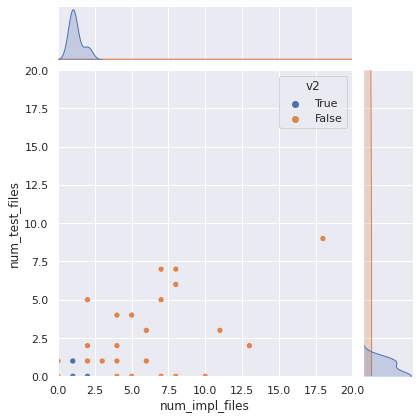

In [32]:
g = sns.jointplot(data=_m, x="num_impl_files", y="num_test_files", xlim=(0,20), ylim=(0,20), hue="v2", hue_order=[True, False])

# RQ4 Representativness of project for testcases were exectued successfully

## Comparing to all mined projects

Ulitmatly the goal is for all project for which test cases were executed successfully to be representative for all Python proejects. More precisely, former project should be representative for all Python project, which have test cases. This filtering step needs to be accounted for. So, first the distribution of the five propertys are inspected for all mined project for which a testsuit was detected, then for all projects which testsuit has been executed successfully.


Datapoints: 13


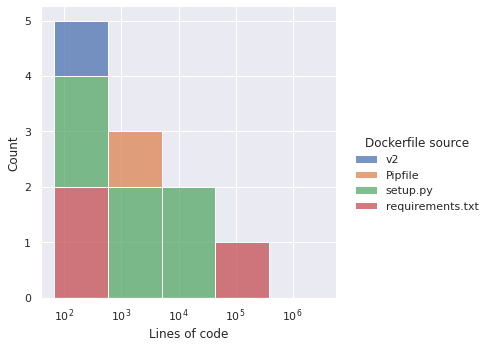

In [33]:
print("Datapoints: {}".format(len(testsuit()["loc"].dropna())))
g = sns.displot(testsuit(), x="loc", hue="dockerfile_source", hue_order=hor, multiple="stack", log_scale=True)
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 13


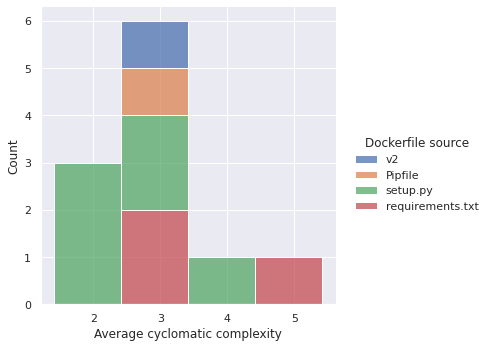

In [34]:
print("Datapoints: {}".format(len(testsuit()["average_complexity"].dropna())))
g = sns.displot(testsuit(), discrete=True, x="average_complexity", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity")

Datapoints: 13


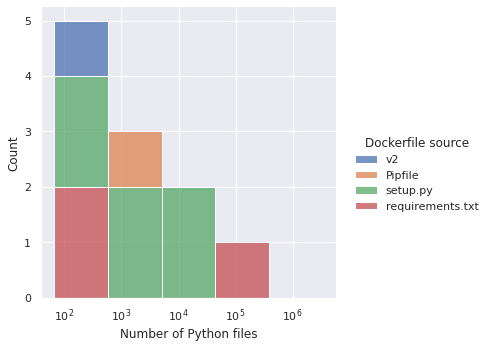

In [35]:
print("Datapoints: {}".format(len(testsuit()["num_impl_files"].dropna())))
g = sns.displot(testsuit(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 13


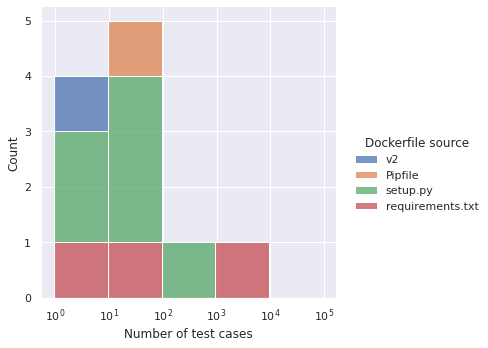

In [36]:
print("Datapoints: {}".format(len(testsuit()["testcase_count"].dropna())))
g = sns.displot(testsuit(), discrete=True, x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack", log_scale=True
           )
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of test cases")

Datapoints: 7


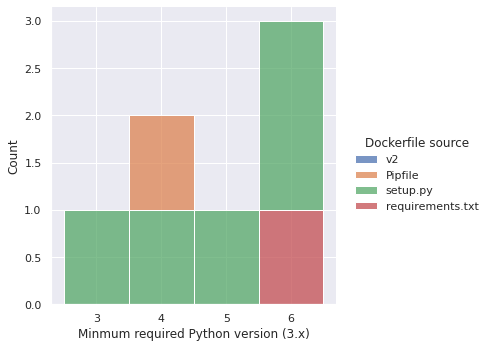

In [37]:
print("Datapoints: {}".format(len(testsuit()["min_python_version"].dropna())))
g = sns.displot(testsuit(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 12


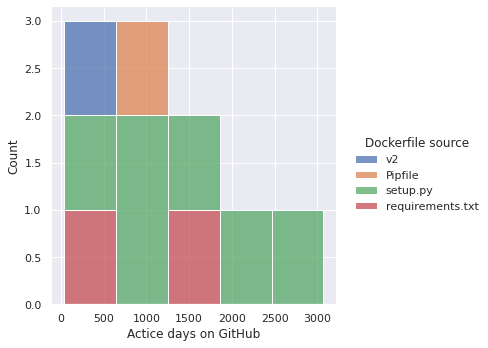

In [38]:
print("Datapoints: {}".format(len(testsuit()["github_repo_active_days"].dropna())))
g = sns.displot(testsuit(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 12


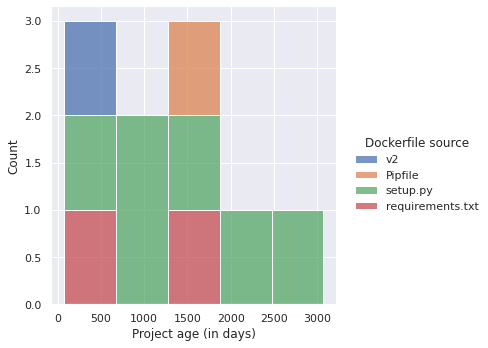

In [39]:
print("Datapoints: {}".format(len(testsuit()["github_repo_age"].dropna())))
g = sns.displot(testsuit(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

Next, consider the same distributions for all projects which test cases have been executed successfully

Datapoints: 6


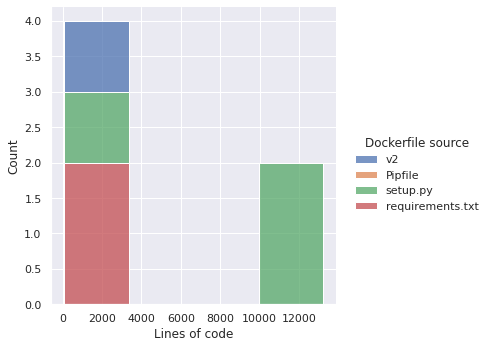

In [40]:
print("Datapoints: {}".format(len(success()["loc"].dropna())))
g = sns.displot(success(), x="loc", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 6


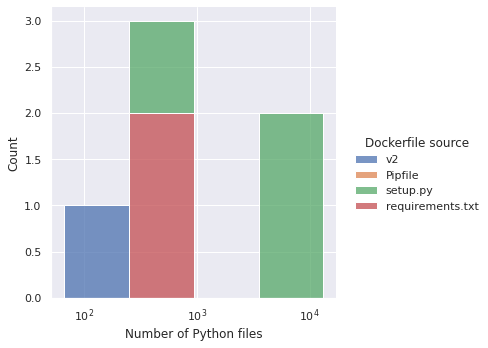

In [41]:
print("Datapoints: {}".format(len(success()["num_impl_files"].dropna())))
g = sns.displot(success(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 6


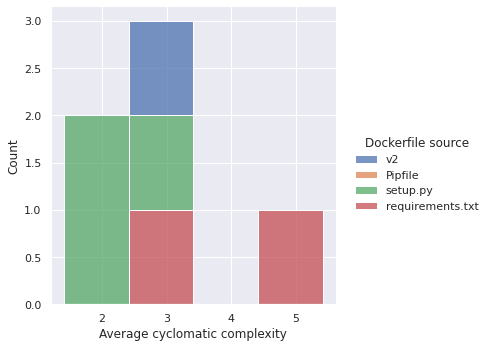

In [42]:
print("Datapoints: {}".format(len(success()["average_complexity"].dropna())))
g = sns.displot(success(), discrete=True, x="average_complexity", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity")

Datapoints: 6


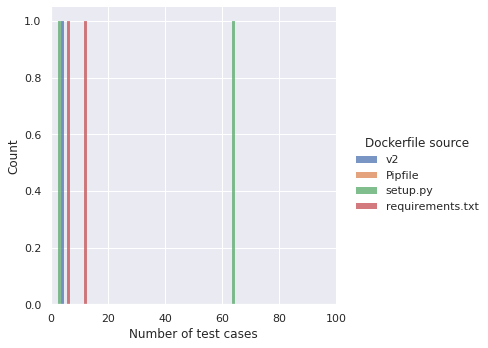

In [43]:
print("Datapoints: {}".format(len(success()["testcase_count"].dropna())))
g = sns.displot(success(), discrete=True, x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack"
           )
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of test cases", xlim=(0,100))

Datapoints: 4


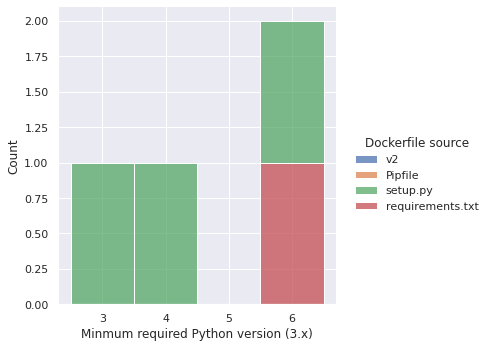

In [44]:
print("Datapoints: {}".format(len(success()["min_python_version"].dropna())))
g = sns.displot(success(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 5


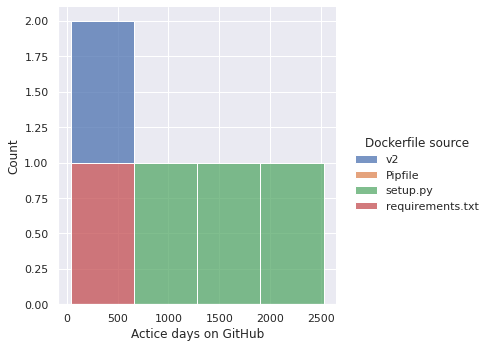

In [45]:
print("Datapoints: {}".format(len(success()["github_repo_active_days"].dropna())))
g = sns.displot(success(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 5


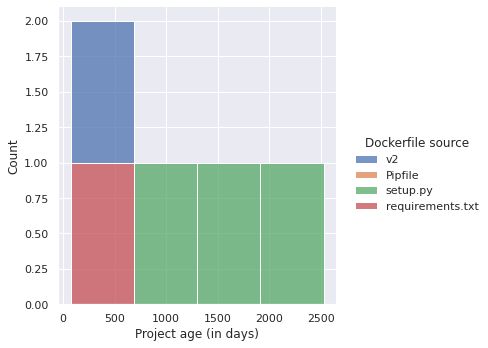

In [46]:
print("Datapoints: {}".format(len(success()["github_repo_age"].dropna())))
g = sns.displot(success(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

Lets have a look at the resuls of the Mann-Whitney U-Test for these variables

In [47]:

print("LOC p-value: {}".format(mwu(testsuit_but_no_success()["loc"].dropna(), success()["loc"].dropna(), alternative="two-sided")[1]))
print("Num code files p-value: {}".format(mwu(testsuit_but_no_success()["num_impl_files"].dropna(), success()["num_impl_files"].dropna(), alternative="two-sided")[1]))
print("Complexity p-value: {}".format(mwu(testsuit_but_no_success()["average_complexity"].dropna(), success()["average_complexity"].dropna(), alternative="two-sided")[1]))
print("Testcase count p-value: {}".format(mwu(testsuit_but_no_success()["testcase_count"].dropna(), success()["testcase_count"].dropna(), alternative="two-sided")[1]))
print("Version p-value: {}".format(mwu(testsuit_but_no_success()["min_python_version"].dropna(), success()["min_python_version"].dropna(), alternative="two-sided")[1]))
print("Active days p-value: {}".format(mwu(testsuit_but_no_success()["github_repo_active_days"].dropna(), success()["github_repo_active_days"].dropna(), alternative="two-sided")[1]))
print("Age p-value: {}".format(mwu(testsuit_but_no_success()["github_repo_age"].dropna(), success()["github_repo_age"].dropna(), alternative="two-sided")[1]))

LOC p-value: 0.17473582321524717
Num code files p-value: 0.1525627236365771
Complexity p-value: 0.7209848619016708
Testcase count p-value: 0.11558189995138274
Version p-value: 1.0
Active days p-value: 0.32985919465547675
Age p-value: 0.41679281184762706


## Comparing to all projects for which a dockerimage has been build and which have a testsuit

This section assesses whether the mechanism used for executing the testsuit preserves representativness.

For this the same template as above is used but the projects for which the testsuit has been executed successfully is compared to all project for which a docker image has been build and that have a test suit.

The distributions for all proejcts with successfull testsuit execution are already shown above.
So only the distributions for all projects for which a dockerimage has been build and which have a testsuit are shown below

Datapoints: 9


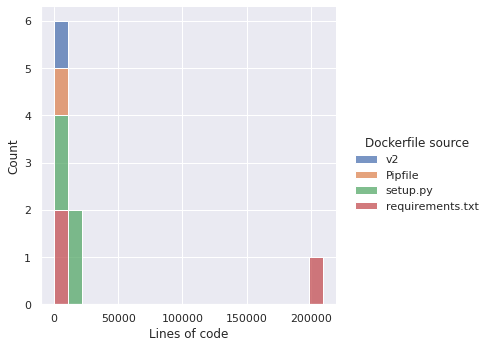

In [48]:
print("Datapoints: {}".format(len(executed()["loc"].dropna())))
g = sns.displot(executed(), x="loc", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 9


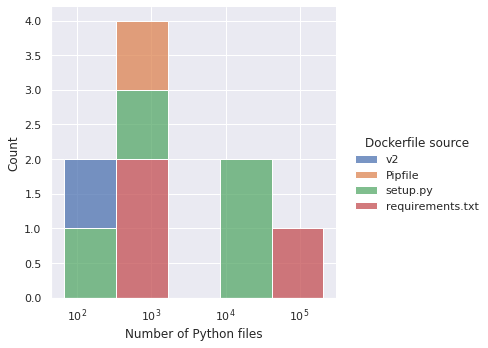

In [49]:
print("Datapoints: {}".format(len(executed()["num_impl_files"].dropna())))
g = sns.displot(executed(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 9


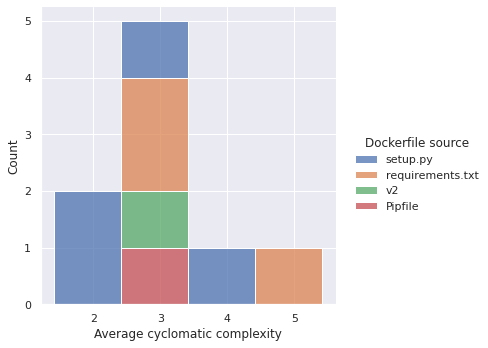

In [50]:
print("Datapoints: {}".format(len(executed()["average_complexity"].dropna())))
g = sns.displot(executed(), discrete=True, x="average_complexity", hue="dockerfile_source", multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity")

Datapoints: 9


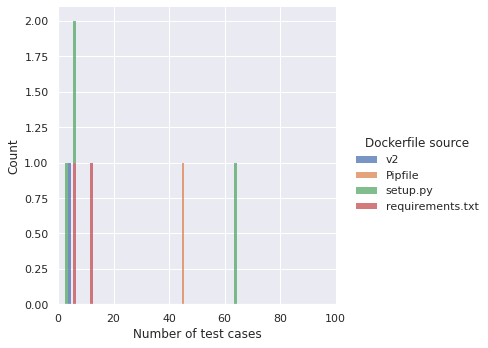

In [51]:
print("Datapoints: {}".format(len(executed()["testcase_count"].dropna())))
g = sns.displot(executed(), discrete=True, x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of test cases", xlim=(0,100))

Datapoints: 6


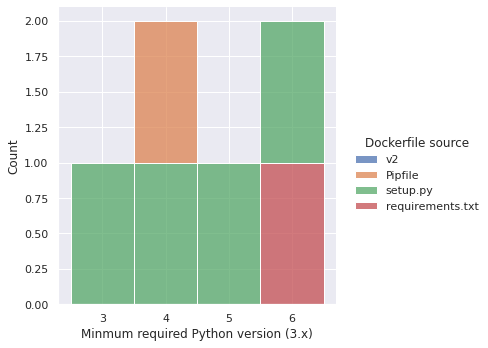

In [52]:
print("Datapoints: {}".format(len(executed()["min_python_version"].dropna())))
g = sns.displot(executed(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 8


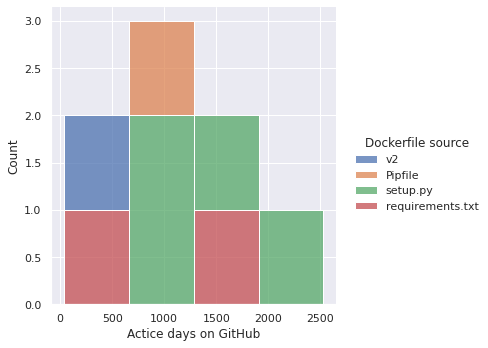

In [53]:
print("Datapoints: {}".format(len(executed()["github_repo_active_days"].dropna())))
g = sns.displot(executed(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 8


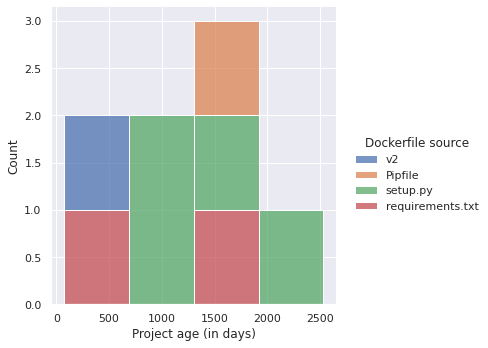

In [54]:
print("Datapoints: {}".format(len(executed()["github_repo_age"].dropna())))
g = sns.displot(executed(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

Another interesting property that can be inspected when comparing these groups is the number of pip and apt dependencies.
The graph for build but unsuccessful and successful proejects are shown down below

Datapoints: 9


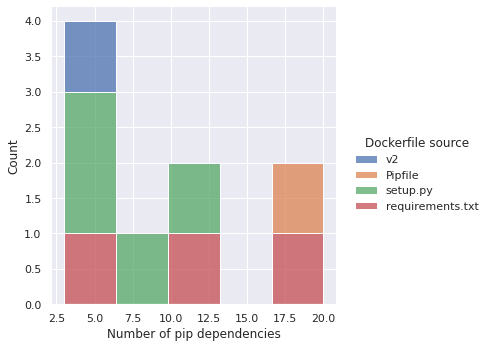

In [55]:
print("Datapoints: {}".format(len(executed()["pip_dependency_count"].dropna())))
g = sns.displot(executed(), x="pip_dependency_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of pip dependencies")

Datapoints: 9


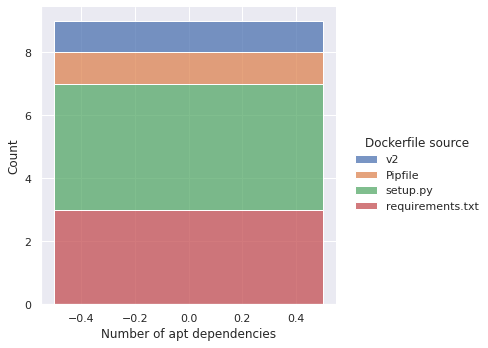

In [56]:
print("Datapoints: {}".format(len(executed()["apt_dependency_count"].dropna())))
g = sns.displot(executed(), x="apt_dependency_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of apt dependencies")

Now compare this to the number of dependencies, for which the testcases were successfully executed

Datapoints: 6


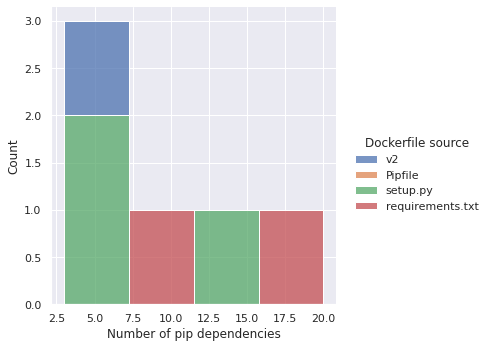

In [57]:
print("Datapoints: {}".format(len(success()["pip_dependency_count"].dropna())))
g = sns.displot(success(), x="pip_dependency_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of pip dependencies")

Datapoints: 6


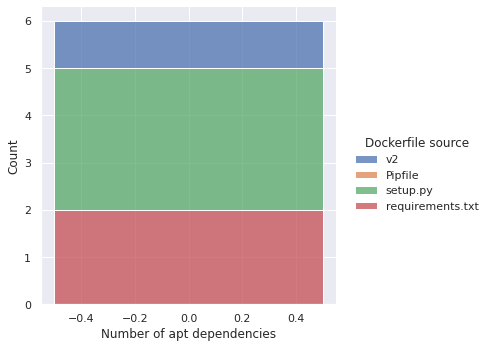

In [58]:
print("Datapoints: {}".format(len(success()["apt_dependency_count"].dropna())))
g = sns.displot(success(), x="apt_dependency_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of apt dependencies")

Consider the p-values for comparing the distributions of the graphs above

In [59]:
print("LOC p-value: {}".format(mwu(executed_but_no_success()["loc"].dropna(), success()["loc"].dropna(), alternative="two-sided")[1]))
print("Num code files p-value: {}".format(mwu(executed_but_no_success()["num_impl_files"].dropna(), success()["num_impl_files"].dropna(), alternative="two-sided")[1]))
print("Complexity p-value: {}".format(mwu(executed_but_no_success()["average_complexity"].dropna(), success()["average_complexity"].dropna(), alternative="two-sided")[1]))
print("Testcase count p-value: {}".format(mwu(executed_but_no_success()["testcase_count"].dropna(), success()["testcase_count"].dropna(), alternative="two-sided")[1]))
print("Version p-value: {}".format(mwu(executed_but_no_success()["min_python_version"].dropna(), success()["min_python_version"].dropna(), alternative="two-sided")[1]))
print("Active days p-value: {}".format(mwu(executed_but_no_success()["github_repo_active_days"].dropna(), success()["github_repo_active_days"].dropna(), alternative="two-sided")[1]))
print("Age p-value: {}".format(mwu(executed_but_no_success()["github_repo_age"].dropna(), success()["github_repo_age"].dropna(), alternative="two-sided")[1]))
print("Pip dependencies p-value: {}".format(mwu(executed_but_no_success()["pip_dependency_count"].dropna(), success()["pip_dependency_count"].dropna(), alternative="two-sided")[1]))
#  print("Apt dependencies p-value: {}".format(mwu(executed_but_no_success()["apt_dependency_count"].dropna(), success()["apt_dependency_count"].dropna(), alternative="two-sided")[1]))

LOC p-value: 0.6985353583033387
Num code files p-value: 0.6040655312875796
Complexity p-value: 0.5186050164287256
Testcase count p-value: 0.4366607090489947
Version p-value: 1.0
Active days p-value: 0.765594483995764
Age p-value: 0.765594483995764
Pip dependencies p-value: 0.6040655312875796


# RQ5: Results of successful testcase executions

In the total number of successful test case executions is

In [60]:
len(success())

6

The distribution of diffent test case results is:

Mean: 86.16666666666667


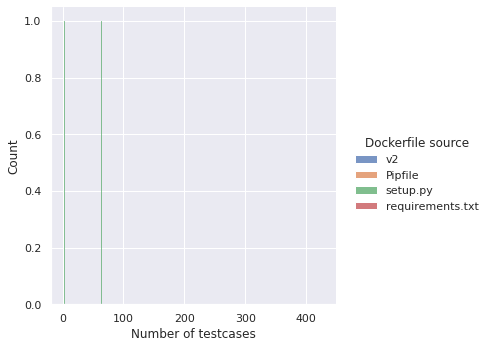

In [61]:
print("Mean: {}".format(mean(success()["testcase_count"])))
g = sns.displot(success(), discrete=True, x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of testcases")

Lets inspect the distribution of the different test case results

Mean: 81.5


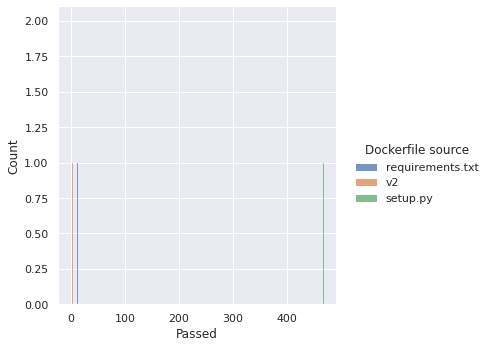

In [62]:
print("Mean: {}".format(mean(success()["passed"])))
g = sns.displot(success(), discrete=True, x="passed", hue="dockerfile_source", multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Passed")

Mean: 9.0


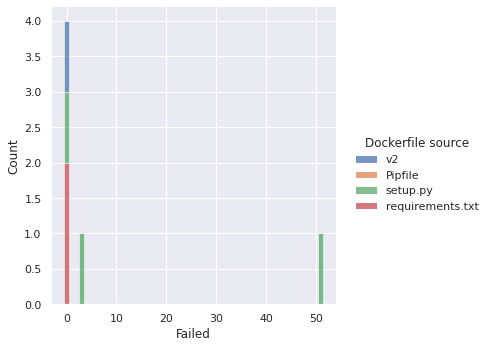

In [63]:
print("Mean: {}".format(mean(success()["failed"])))
g = sns.displot(success(), discrete=True, x="failed", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Failed")

Mean: 1.0


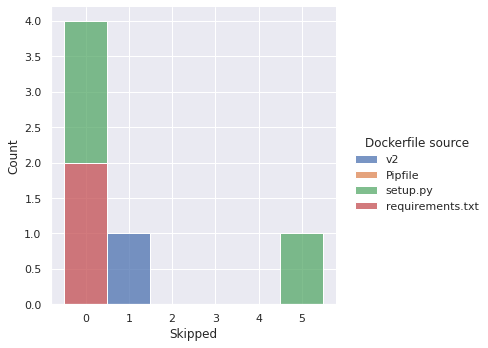

In [64]:
print("Mean: {}".format(mean(success()["skipped"])))
g = sns.displot(success(), discrete=True, x="skipped", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Skipped")

Mean: 1.0


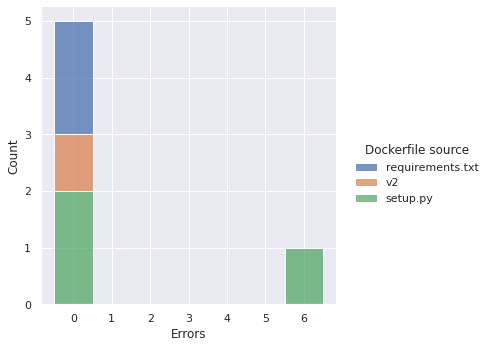

In [65]:
print("Mean: {}".format(mean(success()["errors"])))
g = sns.displot(success(), discrete=True, x="errors", hue="dockerfile_source", multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Errors")

Mean: 64.24100867849518


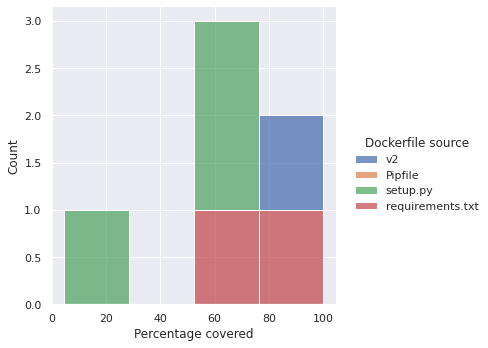

In [66]:
print("Mean: {}".format(mean(success()["percentage_covered"])))
g = sns.displot(success(), x="percentage_covered", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Percentage covered")